In [319]:
import pandas as pd

In [343]:
import numpy as np 
from io import StringIO
from typing import Dict
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

import matplotlib 
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [321]:
def string_to_pandas(text):
    stringio = StringIO(text[1])
    df = pd.read_csv(stringio).drop('Unnamed: 0', axis=1)
    return get_keys(text[0]), df

def get_keys(x):
    try:
        name = os.path.basename(x)
        return "".join([s for s in name if s.isdigit()])
    except (IndexError, KeyError):
        return '', ''
    
def concat(x):
    train = x[1][0][1]
    train["train"] = 1
    
    val = x[1][1][1]
    val["train"] = 0
    
    train = pd.concat([train, gene_expression_train_bc.value], axis=1)
    val = pd.concat([val, gene_expression_validation_bc.value], axis=1)

    
    return pd.concat([train, val], axis=0, ignore_index=True)    


In [4]:
validation_rdd = sc.wholeTextFiles("gs://conrad-project/validation_prediction/spark_input_data/validation_combat_9_03_18/*", minPartitions=500)
training_rdd = sc.wholeTextFiles("gs://conrad-project/validation_prediction/spark_input_data/train_combat_9_03_18/*", minPartitions=500)

In [5]:
gene_expression_train = spark.read.option("header", True).csv("gs://conrad-project/validation_prediction/spark_input_data/training_set_gene_expression.csv").toPandas()
gene_expression_validation = spark.read.option("header", True).csv("gs://conrad-project/validation_prediction/spark_input_data/validation_set_gene_expression.csv").toPandas()

In [6]:
cols = [ "gene_" + c for c in gene_expression_train.columns.tolist()]
cols[0] = "name"
gene_expression_train.columns = cols
print(len(set(cols)))

cols = [ "gene_" + c for c in gene_expression_validation.columns.tolist()]
cols[0] = "name"
gene_expression_validation.columns = cols
print(len(set(cols)))

4684
4684


In [7]:
gene_expression_train_bc = sc.broadcast(gene_expression_train)
gene_expression_validation_bc = sc.broadcast(gene_expression_validation)

In [8]:
validation_rdd = validation_rdd.map(lambda x: string_to_pandas(x)).keyBy(lambda x: get_keys(x[0]))
training_rdd = training_rdd.map(lambda x: string_to_pandas(x)).keyBy(lambda x: get_keys(x[0]))
joined_rdd = training_rdd.join(validation_rdd, numPartitions=500).map(concat)


In [9]:
test = validation_rdd.take(1)[0]

In [10]:
t = joined_rdd.take(1)[0]

In [228]:
def forecast(data, target, features, clf):

    data = data.apply(pd.to_numeric, errors="ignore")
    data[target] = np.log(data[target])
    if data.shape[0] < 10:
        return []

    data = data.reset_index(drop=True)
    data_train = data[data["train"] == 1]
    data_test  =  data[(data["train"] == 0)]

    data_train = data_train.replace([np.inf, -np.inf], np.nan)
    data_test = data_test.replace([np.inf, -np.inf], np.nan)
    data_train = data_train.dropna(subset=features+[target])
    data_test = data_test.dropna(subset=features+[target])
    
    
    importances = []
    if data_test.shape[0] > 0:
        num_training = data_train.shape[0]
        df = pd.get_dummies(pd.concat([data_train, data_test])[features])

        X_train = df.iloc[:num_training, :]
        X_test = df.iloc[num_training:, :]

        y_train = data_train[target].values.ravel()
        y_test = data_test[target].values.ravel()

        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        data_test["prediction"] = np.exp(prediction)
        data_test["prediction_actual"] = np.exp(y_test)
        feature_imp = pd.Series(clf.feature_importances_)
        feature_imp.index = X_test.columns

        importances.append(feature_imp)
        for r in range (0, 0):
            np.random.shuffle(y_train)
            clf.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            feature_imp = pd.Series(clf.feature_importances_)
            feature_imp.index = X_test.columns
            importances.append(feature_imp)
            data_test["prediction_{}".format(r)] = np.exp(prediction)
        return [data_test.filter(regex="prediction*"), pd.DataFrame(importances)]
    return []

In [229]:
clf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True,
                                oob_score=True, n_jobs=-1, random_state=None,
                                verbose=0, warm_start=False)


In [230]:
test = joined_rdd.take(1)[0]
features = test.drop(['BMI.catg', 'BMI.norm', 'name', 'train'], axis=1).columns.tolist()

In [231]:
forecast_rdd = joined_rdd.map(lambda x: forecast(x, "BMI.norm", features, clf))
predictions = forecast_rdd.collect()

In [232]:
results_pred = []
importances = []
for i, p in enumerate(predictions):
    pred = p[0]
    impor = p[1]
    pred["imputation_set"] = i
    impor["imputation_set"] = i
    importances.append(impor)
    results_pred.append(pred)
    

In [234]:
results_pred = pd.concat(results_pred)
importances = pd.concat(importances)
results_pred.to_csv("/home/tomi/results_pred.scv", index=False)
importances.to_csv("/home/tomi/importances.scv", index=False)

In [317]:

mean_squared_error(results_pred["prediction_actual"], results_pred["prediction"])

                   

62.155366794252984

In [235]:
importances = importances.set_index(["imputation_set"])
importances_rank = importances.apply(lambda x: np.argsort(x), axis=1)

In [309]:
importances_rank_med = importances_rank.max(axis=0)#.sort_values()
inds = np.digitize(importances_rank_med, np.percentile(importances_rank_med, np.arange(0, 100, 10)))
inds = pd.Series(inds)
inds.index = importances_rank_med.index
importances_rank_med = pd.concat([importances_rank_med, inds],axis=1)
importances_rank_med.columns = ["average_rank", "decile"]

In [352]:
groups_deciles = importances_rank_med.groupby("decile")

In [ ]:
predictions_by_groups = []
for g in groups_deciles:
    genes_to_test = g[1].index.tolist()
    forecast_rdd = joined_rdd.map(lambda x: forecast(x, "BMI.norm", genes_to_test, clf))
    pred = forecast_rdd.collect()
    results_pred = []
    for i, p in enumerate(pred):
        pred = p[0]
        pred["imputation_set"] = i
        results_pred.append(pred)
    results_pred = pd.concat(results_pred)
    results_pred["decile"] = g[0]
    predictions_by_groups.append(results_pred)
    
predictions_by_groups = pd.concat(predictions_by_groups)
predictions_by_groups["error"] = ((predictions_by_groups["prediction_actual"] - predictions_by_groups["prediction"]))

In [ ]:
sns.boxplot(x="decile", y="error", data=predictions_by_groups)

In [ ]:
predictions_by_groups.groupby(["decile"]).apply(lambda x: mean_squared_error(x["prediction_actual"],x["prediction"])).plot()

In [347]:
groups_deciles = [g[1]for g in importances_rank_med.groupby("decile")]
groups_to_test = []
predictions_by_groups = []

for i in range(0,len(groups_deciles)):
    
    genes_to_test = []
    for j in range(0, i+1):
        genes_to_test.append(groups_deciles[j])
    genes_to_test = pd.concat(genes_to_test).index.tolist()
    
    forecast_rdd = joined_rdd.map(lambda x: forecast(x, "BMI.norm", genes_to_test, clf))
    pred = forecast_rdd.collect()
    results_pred = []
    for k, p in enumerate(pred):
        pred = p[0]
        pred["imputation_set"] = k
        results_pred.append(pred)
    results_pred = pd.concat(results_pred)
    results_pred["decile"] = i
    predictions_by_groups.append(results_pred)
    
predictions_by_groups = pd.concat(predictions_by_groups)
predictions_by_groups["error"] = ((predictions_by_groups["prediction_actual"] - predictions_by_groups["prediction"]))


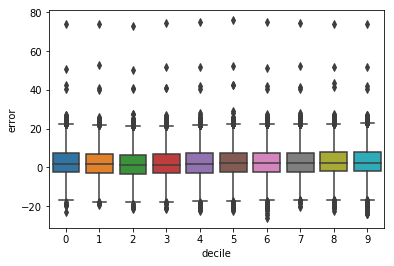

In [348]:
sns.boxplot(x="decile", y="error", data=predictions_by_groups)

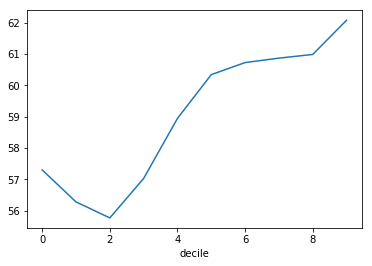

In [349]:
predictions_by_groups.groupby(["decile"]).apply(lambda x: mean_squared_error(x["prediction_actual"],x["prediction"])).plot()